## Capstone Project : New York City Taxi Fare Prediction
Bhaskar Das
Springboard Data Science Career Track, May 2019 cohort

### Import Libraries

In [1]:
# load some default Python modules
import numpy as np # Linear algebra
import pandas as pd # Data processing, CSV file I/O
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Pandas display options
r_seed = 100 # Set random seed 

from tqdm import tqdm # Decorate an iterable object. Used for reading large input file

import os # Reading the input files we have access to
import warnings # Ignore warnings
warnings.simplefilter("ignore")

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns
palette = sns.color_palette('Paired', 10)

### 1.1 Reading Data

The data contain 55 million rows out of which we will work with only 2 million rows to speed up our model. Later we will use more data to evaluate the accuracy of our model. For the longitude and latitude values, we will use float32 insted of float64 to train data faster. While reading the data, we will treat the variable "pickup_datetime" as a date and drop the variable "key" since it is a unique identifier.

In [2]:
%%time

TRAIN_PATH = './input/train.csv'

# Set columns to most suitable type to optimize for memory usage
traintypes = {'fare_amount': 'float32', #'key':'object', # dropped ID variable
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())

chunksize = 2_000_000

df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm(pd.read_csv(TRAIN_PATH, usecols=cols, dtype=traintypes, chunksize=chunksize)):
     
    # Using parse_dates would be much slower
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk) 
    
# Merge all dataframes into one dataframe
train_df_all = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

28it [01:41,  3.63s/it]


Wall time: 1min 44s


In [3]:
train_df = train_df_all.head(2_000_000) # load 2 million rows to train model

# See what we have loaded
train_df.head()    

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1


In [4]:
# check statistics of the features
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2000000.000,2000000.000,2000000.000,1999986.000,1999986.000,2000000.000
mean,11.348,-72.523,39.930,-72.524,39.928,1.684
std,9.853,12.868,7.983,12.775,10.324,1.315
min,-62.000,-3377.681,-3458.665,-3383.297,-3461.541,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,1273.310,2856.442,2621.628,3414.307,3345.917,208.000


We can observe that there are a number of outliers present in the data:

- fare_amount contains negative value.
- the latitude and longitude values.
- passenger_count contains 0 value.

### 2. Missing value treatment

We will remove observations with missing entries.

In [5]:
# Check missing values
print(train_df.isnull().sum())

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64


Only two columns contains missing values and we have deleted those rows.

In [6]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna()
#train_df = train_df[train_df.fare_amount>=0]
print('New size: %d\n' % len(train_df))
train_df.info()

Old size: 2000000
New size: 1999986

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999986 entries, 0 to 1999999
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 70.6 MB


### 3. Outlier Detection and Treatment

#### Fare Amount

In [9]:
# Data backup
train_df2 = train_df.copy()

In [163]:
# load backup data
# train_df = train_df2.copy()

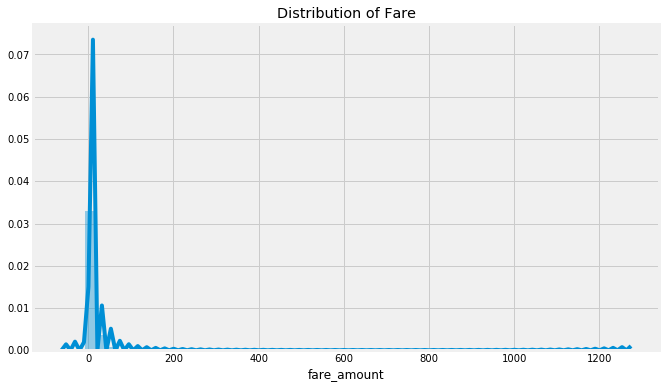

In [164]:
# Examine the Target Variable
plt.figure(figsize = (10, 6))
sns.distplot(train_df['fare_amount']);
plt.title('Distribution of Fare');

In [166]:
print("Negative fares: ", len(train_df[train_df['fare_amount'] < 0]))
print("$0 fares: ", len(train_df[train_df['fare_amount'] == 0]))
print("Less than minimum $2.5 fares: ", len(train_df[train_df['fare_amount'] < 2.5]))
print("Fares between $2.5 and $100: ", len(train_df[train_df['fare_amount'].between(left=2.5,right=100)]))
print("Fares greater than $100: ", len(train_df[train_df['fare_amount'] > 100]))

Negative fares:  77
$0 fares:  56
Less than minimum $2.5 fares:  155
Fares between $2.5 and $100:  1999046
Fares greater than $100:  785


Most of the rides lies between \\$2.5 and \\$100. 

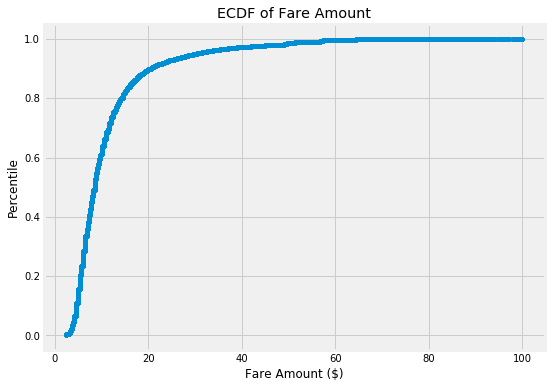

In [169]:
def ecdf(x):
    """Empirical cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

fare_100 = train_df[train_df['fare_amount'].between(left=2.5,right=100)]

xs, ys = ecdf(fare_100['fare_amount'])
plt.figure(figsize = (8, 6))
plt.plot(xs, ys, '.')
plt.ylabel('Percentile'); plt.title('ECDF of Fare Amount'); plt.xlabel('Fare Amount ($)');

From the ECDF plot, we can observe that most of the rides are below \\$20. Nest, we will remove fares less than \\$2.5, which is the minimum fare.

In [170]:
from collections import Counter

print(Counter(train_df['fare_amount']<2.5))
print('Old size: %d' % len(train_df))

train_df = train_df.drop(train_df[train_df['fare_amount']<2.5].index, axis=0)
print('New size: %d' % len(train_df))
print(train_df.shape)

#no more negative values in the fare field
print(train_df['fare_amount'].describe())
#train_df['fare_amount'].sort_values(ascending=False)
#train_df['fare_amount'].value_counts().sort_values(ascending=False)
#train_df['fare_amount'].value_counts().sort_index(ascending=False).head(20)

Counter({False: 1999831, True: 155})
Old size: 1999986
New size: 1999831
(1999831, 7)
count   1999831.000
mean         11.349
std           9.852
min           2.500
25%           6.000
50%           8.500
75%          12.500
max        1273.310
Name: fare_amount, dtype: float64


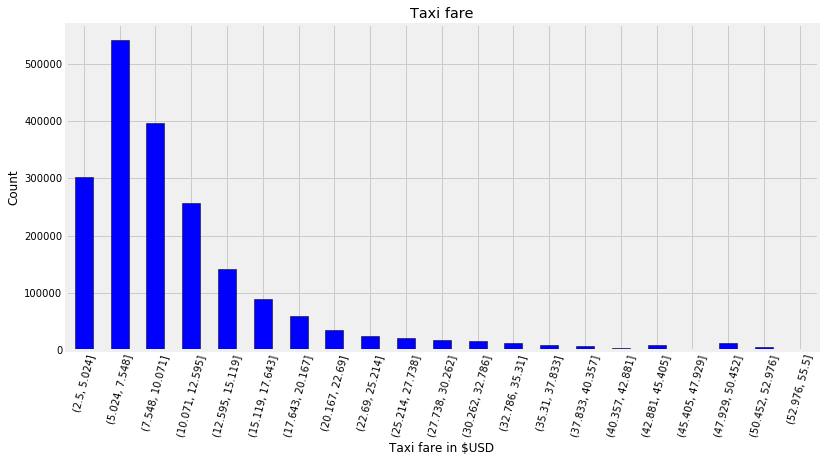

In [171]:
# Fare into a separate dataframe
fare_data = train_df[['fare_amount']]

# Bin the age data
fare_data['fare_bin'] = pd.cut(train_df['fare_amount'], bins = np.linspace(2.5, 55.5, num = 22))

plt.figure(figsize = (12, 6))

# Graph the fare bins as a bar plot
fare_data['fare_bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Taxi fare in $USD'); plt.ylabel('Count')
plt.title('Taxi fare');


The minimum taxi fares in New York City starts from \\$2.5. Therefore, all the records having values less than \\$2.50 are removed. 

#### Passenger Counts

In [172]:
# data backup
train_df3 = train_df.copy()

In [186]:
# load backup data
# train_df = train_df3.copy()

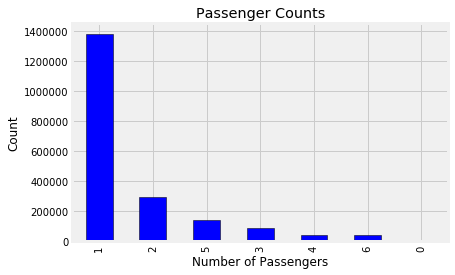

In [190]:
train_df['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts'); plt.xlabel('Number of Passengers'); plt.ylabel('Count');

Passenger counts can not be more than 6. Therefore, all recordes will be deleted where passenger counts is more than 6.

In [189]:
print('Old size: %d' % len(train_df))
train_df = train_df.loc[train_df['passenger_count'] <= 6]
print('New size: %d' % len(train_df))

Old size: 1999831
New size: 1999829


#### Location Data

In [191]:
# data backup
train_df4 = train_df.copy()

In [294]:
# load backup data
# train_df = train_df4.copy()

Remove outlier from location data.

In [297]:
for col in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
    print(f'{col.capitalize():17}: 2.5% = {round(np.percentile(train_df[col], 2.5), 2):5} \t 97.5% = \
    {round(np.percentile(train_df[col], 97.5), 2)}')

Pickup_latitude  : 2.5% = 40.64 	 97.5% =     40.8
Pickup_longitude : 2.5% = -74.01 	 97.5% =     -73.78
Dropoff_latitude : 2.5% = 40.64 	 97.5% =     40.81
Dropoff_longitude: 2.5% = -74.01 	 97.5% =     -73.78


In [298]:
# Remove latitude and longtiude outliers
train_df = train_df.loc[train_df['pickup_latitude'].between(40, 42)]
train_df = train_df.loc[train_df['pickup_longitude'].between(-75, -72)]
train_df = train_df.loc[train_df['dropoff_latitude'].between(40, 42)]
train_df = train_df.loc[train_df['dropoff_longitude'].between(-75, -72)]

print(f'New number of observations: {train_df.shape[0]}')

New number of observations: 1958184


### 4. Exploratory Data Analysis (EDA)

We will use vizulization methods to find trends, anomalies, patterns, or relationships within the data. EDA helps us to learn more about our data.

#### Correlation Matrix 

The Pearson correlation coefficient gives the correlations between a variable and the target. It gives us an idea of possible relationships within the data.

In [299]:
# data backup
train_df5 = train_df.copy()

In [300]:
# load backup data
# train_df = train_df5.copy()

In [301]:
# Find correlations with the fare_amount and sort
correlations = train_df.corr()['fare_amount'].sort_values()

# Display correlations
print('Correlations:\n', correlations.tail(15))

Correlations:
 pickup_latitude     -0.186
dropoff_latitude    -0.153
passenger_count      0.014
dropoff_longitude    0.282
pickup_longitude     0.372
fare_amount          1.000
Name: fare_amount, dtype: float64


The passenger_count has positive correlation with the fare_amount. The increase in the passenger_count increase fare_amount. 

#### Relationship between number of passengers and fare

Text(0, 0.5, 'Frequency')

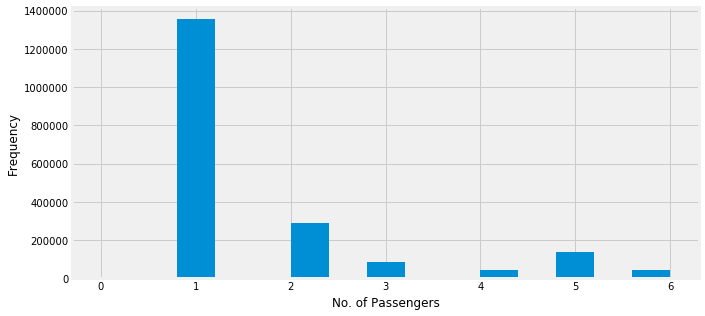

In [302]:
plt.figure(figsize=(10,5))
plt.hist(train_df['passenger_count'], bins=15)
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

Single passengers are the most frequent travellers.

Text(0, 0.5, 'Fare')

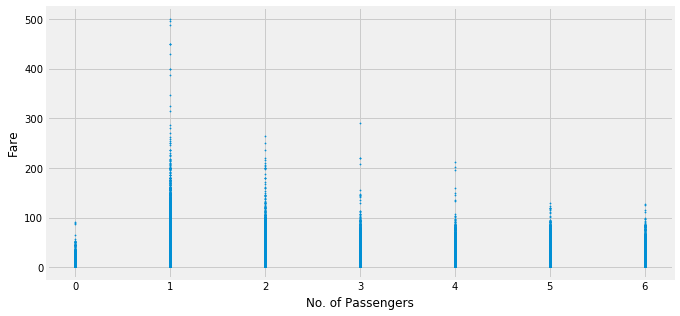

In [303]:
plt.figure(figsize=(10,5))
plt.scatter(x=train_df['passenger_count'], y=train_df['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

The cabs receive heighest fares when thay carry single passengers.

### 4. Feature Engineering

We will create new features out of the data for our machine learning model. 

We will calulate the distance between the pickup and dropoff from thei latitudes and longitudes values by using the Haversine formula. The distance of each ride will be added to our data.

In [304]:
# data backup
train_df6 = train_df.copy()

In [206]:
# load backup data
# train_df = train_df6.copy()

In [305]:
def haversine_distance(df, lat1, long1, lat2, long2):
    R = 6371  #radius of earth in kilometers
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    
    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    #d = R*c
    d = (R * c) #in kilometers
    df['distance'] = d
    #return d

haversine_distance(train_df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [306]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999


We will create the new features, year, month, date, hour, and day_of_week from the pickup_datetime variable.

In [307]:
train_df['year'] = train_df['pickup_datetime'].dt.year
train_df['month'] = train_df['pickup_datetime'].dt.month
train_df['date'] = train_df['pickup_datetime'].dt.day
train_df['day_of_week'] = train_df['pickup_datetime'].dt.dayofweek
train_df['hour'] = train_df['pickup_datetime'].dt.hour

In [308]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,date,day_of_week,hour
0,4.500,2009-06-15 17:26:00+00:00,-73.844,40.721,-73.842,40.712,1,1.031,2009,6,15,0,17
1,16.900,2010-01-05 16:52:00+00:00,-74.016,40.711,-73.979,40.782,1,8.450,2010,1,5,1,16
2,5.700,2011-08-18 00:35:00+00:00,-73.983,40.761,-73.991,40.751,2,1.390,2011,8,18,3,0
3,7.700,2012-04-21 04:30:00+00:00,-73.987,40.733,-73.992,40.758,1,2.799,2012,4,21,5,4
4,5.300,2010-03-09 07:51:00+00:00,-73.968,40.768,-73.957,40.784,1,1.999,2010,3,9,1,7


#### Effect of the date and time of pickup on the fare

Text(0.5, 1.0, 'Effect of the date of pickup on the frequency of ride')

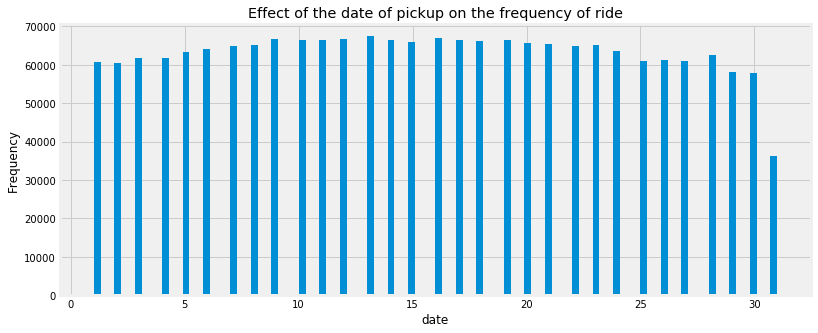

In [309]:
plt.figure(figsize=(12,5))
plt.hist(train_df['date'], bins=100)
plt.xlabel('date')
plt.ylabel('Frequency')
plt.title('Effect of the date of pickup on the frequency of ride')

Text(0.5, 1.0, 'Effect of the date of pickup on the fare')

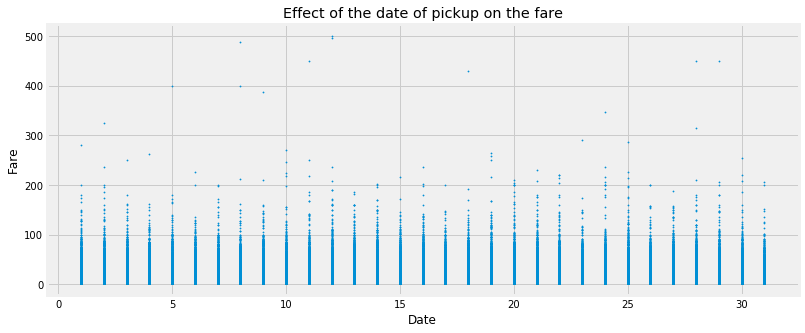

In [310]:
plt.figure(figsize=(12,5))
plt.scatter(x=train_df['date'], y=train_df['fare_amount'], s=1.5)
plt.xlabel('Date')
plt.ylabel('Fare')
plt.title('Effect of the date of pickup on the fare')

From the above figures, it looks like the frequency of ride and the fare are not affected by the date.

Text(0.5, 1.0, 'Time of the day and the the frequency of ride')

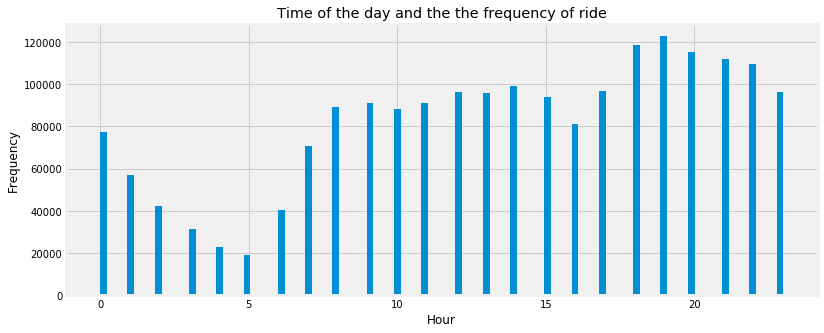

In [311]:
plt.figure(figsize=(12,5))
plt.hist(train_df['hour'], bins=100)
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.title('Time of the day and the the frequency of ride')

The time of the day affect the frequency of the rides. Morning 5 sees the lowest and evening 7 being the heighst.

Text(0.5, 1.0, 'Effect of the time of the day on the fare')

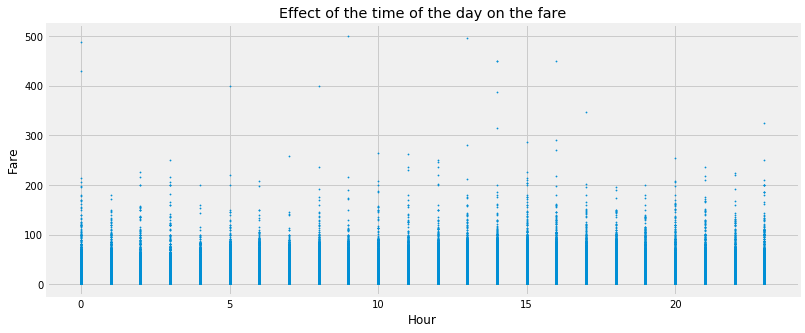

In [312]:
plt.figure(figsize=(12,5))
plt.scatter(x=train_df['hour'], y=train_df['fare_amount'], s=1.5)
plt.xlabel('Hour')
plt.ylabel('Fare')
plt.title('Effect of the time of the day on the fare')

However, the fare is high between 5AM to 9AM and 1PM to 4PM.

#### Effect of the day of the week on the fare

Text(0.5, 1.0, 'Time of the day and the frequency of ride')

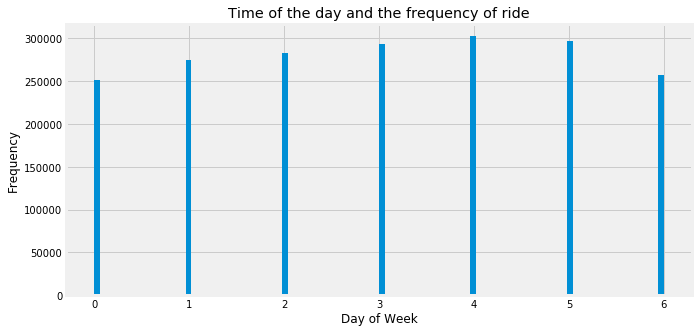

In [313]:
plt.figure(figsize=(10,5))
plt.hist(train_df['day_of_week'], bins=100)
plt.xlabel('Day of Week')
plt.ylabel('Frequency')
plt.title('Time of the day and the frequency of ride')

The day of the week doesn't seem to have much of an influence on the number of taxi rides.

Text(0.5, 1.0, 'Time of the day and the fare of a ride')

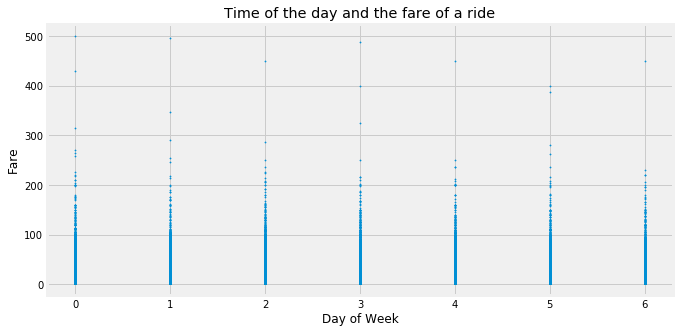

In [314]:
plt.figure(figsize=(10,5))
plt.scatter(x=train_df['day_of_week'], y=train_df['fare_amount'], s=1.5)
plt.xlabel('Day of Week')
plt.ylabel('Fare')
plt.title('Time of the day and the fare of a ride')

The day of the week doesn't seem to have much of an influence on the fare of a rides.

#### Effect of the distance on the fare

In [315]:
train_df_dist = train_df.sort_values(['distance','fare_amount'], ascending=False)

bins_0 = train_df_dist.loc[(train_df_dist['distance'] == 0), ['distance']]
bins_1 = train_df_dist.loc[(train_df_dist['distance'] > 0) & (train_df_dist['distance'] <= 10),['distance']]
bins_2 = train_df_dist.loc[(train_df_dist['distance'] > 10) & (train_df_dist['distance'] <= 50),['distance']]
bins_3 = train_df_dist.loc[(train_df_dist['distance'] > 50) & (train_df_dist['distance'] <= 100),['distance']]
bins_4 = train_df_dist.loc[(train_df_dist['distance'] > 100),['distance']]
bins_0['bins'] = '0'
bins_1['bins'] = '0-10'
bins_2['bins'] = '11-50'
bins_3['bins'] = '51-100'
bins_4['bins'] = '>100'
dist_bins =pd.concat([bins_0,bins_1,bins_2,bins_3,bins_4])

Counter(dist_bins['bins'])

Counter({'0': 21217,
         '0-10': 1838438,
         '11-50': 98134,
         '51-100': 317,
         '>100': 78})

Text(0, 0.5, 'Frequency')

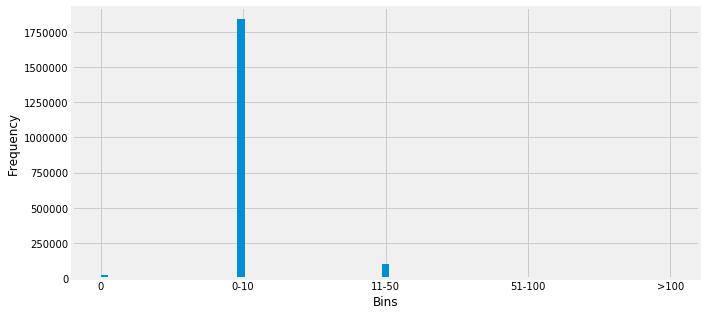

In [316]:
plt.figure(figsize=(10,5))
plt.hist(dist_bins['bins'], bins=75)
plt.xlabel('Bins')
plt.ylabel('Frequency')

Most of the rides are within the short distance, which is within the 50km range.

There are some rows where distance is 0. We will assume that it is due to the waiting time charge when the price is 2.5. Otherwise, we will assume that it is an outlier and we will impute the distance value. 

Calculate distance from fare and update the distance where distance is 0. 

In [319]:
dist_mod = train_df.loc[(train_df['distance']==0)]
dist_mod_up = dist_mod.loc[(dist_mod['fare_amount']>2.5)&(dist_mod['distance']==0)]
dist_mod_up['distance'] = dist_mod_up.apply(lambda row: ((row['fare_amount']-2.50)/1.56), axis=1)

In [325]:
train_df.update(dist_mod_up)

### 5. Machine Learning

In [335]:
# data backup
train_df7 = train_df.copy()

In [366]:
# load backup data
# train_df = train_df7.copy()

In [371]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

labels = train_df['fare_amount']
df = train_df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','distance','year','month','date','day_of_week','hour']]

# train_test_split
trainx, testx, trainy, testy = train_test_split(df, labels, test_size=0.3, random_state=42)
print('train and test data shape: ', trainx.shape , testx.shape , trainy.shape , testy.shape)

train and test data shape:  (1370728, 11) (587456, 11) (1370728,) (587456,)


Root mean squared error and Mean absolute percentage error will be used for model evaluation.

In [368]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

__Linear Regression:__

In [372]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(trainx, trainy)
evaluate(lr, list(df.columns), trainx, testx, trainy, testy)

Training:   rmse = 5.29 	 mape = 24.08
Validation: rmse = 5.25 	 mape = 24.05


__Light Gradient Boosting__

In [373]:
import lightgbm as lgbm

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': -1,
        'verbose': 0,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'subsample_freq': 1,
        'colsample_bytree': 0.6,
        'reg_aplha': 1,
        'reg_lambda': 0.001,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1     
    }

pred_test_y = np.zeros(testx.shape[0])
print(pred_test_y.shape)
train_set = lgbm.Dataset(trainx, trainy, silent=True)
print(train_set)
model = lgbm.train(params, train_set = train_set, num_boost_round=300)
print(model)
pred_test_y = model.predict(testx, num_iteration = model.best_iteration)
print(pred_test_y)

evaluate(model, list(df.columns), trainx, testx, trainy, testy)

(587456,)
[ 5.1552709   7.05941593 10.88512049 ... 18.39593169  7.4031918
  7.7291003 ]
Training:   rmse = 3.64 	 mape = 18.17
Validation: rmse = 3.75 	 mape = 18.21


__Random Forest__

In [374]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 20, max_depth = 20, max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(trainx, trainy)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.7min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=1,
                      warm_start=False)

In [375]:
evaluate(random_forest, list(df.columns), trainx, testx, trainy, testy)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.0s finished


Training:   rmse = 2.45 	 mape = 14.74
Validation: rmse = 3.68 	 mape = 17.63
